In [1]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [2]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 100,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 100,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 100,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 100,5)

suitablearea_biomass = 2500 ## km2 
suitablearea_bgec = 2500 ## km2
suitablearea_msw = 2500 ## km2

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.524  buffer =  0.02524
radius_vspp_wind km =  0.8410000000000001  buffer =  0.00841
radius_spp_solar km =  1.3820000000000001  buffer =  0.01382
radius_vspp_solar km =  0.461  buffer =  0.00461


In [3]:
scenario_SI = 0
coarsenscale = 10
xr_out = xr.open_dataset('Output\\xr_output_all_SSI_' + str(scenario_SI) + "_CS_"+ str(coarsenscale)+ '_.nc')
print(xr_out)
try:
    print("cap_wind = ",xr_out['cap_wind'].sum())
    print("cap_solar = ",xr_out['cap_solar'].sum())
    print("cap_biomass = ",xr_out['cap_biomass'].sum())
    print("cap_bgec = ",xr_out['cap_bgec'].sum())
    print("cap_msw = ",xr_out['cap_msw'].sum())
except:
    print("cap_wind = ",xr_out['cap_wind'].sum())
    print("cap_solar = ",xr_out['cap_solar'].sum())

<xarray.Dataset> Size: 52MB
Dimensions:       (lat: 534, lon: 298)
Coordinates:
  * lat           (lat) float64 4kB 5.628 5.656 5.683 ... 20.38 20.41 20.43
  * lon           (lon) float64 2kB 97.36 97.39 97.41 ... 105.6 105.6 105.6
Data variables: (12/31)
    lccs_class    (lat, lon) int64 1MB ...
    SI_BGEC       (lat, lon) float64 1MB ...
    SI_Biomass    (lat, lon) float64 1MB ...
    SI_Solar      (lat, lon) float64 1MB ...
    SI_Wind       (lat, lon) float64 1MB ...
    SI_BGWW       (lat, lon) float64 1MB ...
    ...            ...
    region        (lat, lon) <U2 1MB ...
    cap_wind      (lat, lon) float64 1MB ...
    cap_solar     (lat, lon) float64 1MB ...
    cap_biomass   (lat, lon) float64 1MB ...
    cap_bgec      (lat, lon) float64 1MB ...
    cap_msw       (lat, lon) float64 1MB ...
cap_wind =  <xarray.DataArray 'cap_wind' ()> Size: 8B
array(9599.9996)
cap_solar =  <xarray.DataArray 'cap_solar' ()> Size: 8B
array(27424.9986)
cap_biomass =  <xarray.DataArray 'cap_biom

In [4]:
try:
    df_wind = xr_out.to_dataframe()
    xr_out.close()
    df_wind.reset_index(inplace=True)
    df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
    df_wind.crs = {'init': 'epsg:4326'}
    print(len(df_wind))
    for i,c in enumerate(df_wind.columns):
        if c not in (['lon','lat','SI_Wind','SI_Wind_max','SI_Wind_min','region','ADM1_EN','cap_wind','AVA_Wind','geometry']):
            df_wind = df_wind.drop(columns=c)

    df_wind = df_wind.loc[df_wind['cap_wind'] > 0]
    df_wind.reset_index(inplace=True,drop=False)
    df_wind.crs = {'init': 'epsg:4326'}
    df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)
    df_wind = df_wind.set_geometry('buffer')

    df_wind.to_csv('Output\\Output_wind_all_SSI_' + str(scenario_SI) + "_CS_" + str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_wind)
    
except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132


d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


      index        lat         lon   SI_Wind  AVA_Wind  SI_Wind_max  \
0     24825   7.933333   99.886111  2.257849  9.000000     2.380651   
1     26015   8.044444   99.830556  2.289972  9.000000     2.358548   
2     26016   8.044444   99.858333  2.350855  9.000000     2.356910   
3     26313   8.072222   99.830556  2.224268  8.910001     2.309742   
4     26314   8.072222   99.858333  2.312497  9.000000     2.358581   
..      ...        ...         ...       ...       ...          ...   
262  135209  18.211111  103.330556  1.583212  8.910000     2.002350   
263  135212  18.211111  103.413889  1.539902  8.190001     1.978245   
264  135805  18.266667  103.330556  1.690888  8.910000     1.943495   
265  135806  18.266667  103.358333  1.946305  9.000000     1.949427   
266  135807  18.266667  103.386111  1.797154  9.000000     2.035941   

     SI_Wind_min              ADM1_EN region  cap_wind  \
0       1.575864          Phatthalung     R3    40.500   
1       2.215186  Nakhon Si Tha

C:\Users\595078\AppData\Local\Temp\ipykernel_16224\1157218713.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)


In [5]:
try:
    df_solar = xr_out.to_dataframe()
    df_solar.reset_index(inplace=True)
    df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
    df_solar.crs = {'init': 'epsg:4326'}
    print(len(df_solar))
    for i,c in enumerate(df_solar.columns):
        if c not in (['lon','lat','SI_Solar','SI_Solar_max','SI_Solar_min','region','ADM1_EN','cap_solar','AVA_Solar','geometry']):
            df_solar = df_solar.drop(columns=c)

    df_solar = df_solar.loc[df_solar['cap_solar'] > 0]
    df_solar.reset_index(inplace=True,drop=False)
    df_solar.crs = {'init': 'epsg:4326'}
    df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)
    df_solar = df_solar.set_geometry('buffer')

    df_solar.to_csv('Output\\Output_solar_all_SSI_' + str(scenario_SI) + "_CS_" + str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_solar)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
      index        lat         lon  SI_Solar  AVA_Solar  SI_Solar_max  \
0     15895   7.100000  100.163889  2.368814   9.000000      2.469754   
1     15905   7.100000  100.441667  2.499166   8.910000      2.565582   
2     16494   7.155556  100.247222  2.240897   8.190001      2.502391   
3     16788   7.183333  100.136111  2.267291   8.730001      2.412191   
4     17086   7.211111  100.136111  2.220476   8.460001      2.472339   
..      ...        ...         ...       ...        ...           ...   
217  130130  17.738889  102.969444  1.908964   7.650001      2.473501   
218  130146  17.738889  103.413889  1.946600   7.740001      2.316014   
219  130737  17.794444  103.275000  2.082083   8.190001      2.483852   
220  132216  17.933333  102.969444  1.959903   8.010000      2.257692   
221  132545  17.961111  103.830556  2.071288   8.550001      2.224511   

     SI_Solar_min      ADM1_EN region  cap_solar                    geometry  \
0         2.33396        Satun     R

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_16224\3812903428.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)


In [6]:
try:
    df_biomass = xr_out.to_dataframe()
    df_biomass.reset_index(inplace=True)
    df_biomass = gpd.GeoDataFrame(df_biomass, geometry =gpd.points_from_xy(df_biomass['lon'],df_biomass['lat']))
    df_biomass.crs = {'init': 'epsg:4326'}
    print(len(df_biomass))
    for i,c in enumerate(df_biomass.columns):
        if c not in (['lon','lat','SI_Biomass','SI_Biomass_max','SI_Biomass_min','region','ADM1_EN','cap_biomass','geometry']):
            df_biomass = df_biomass.drop(columns=c)

    df_biomass = df_biomass.loc[df_biomass['cap_biomass'] > 0]
    df_biomass.reset_index(inplace=True,drop=False)
    df_biomass.crs = {'init': 'epsg:4326'}
    df_biomass['buffer'] = df_biomass['geometry'].buffer(np.round(np.sqrt(suitablearea_biomass/(3.14)) / 150,5),cap_style = 3)
    df_biomass = df_biomass.set_geometry('buffer')

    df_biomass.to_csv('Output\\Output_biomass_all_SSI_' + str(scenario_SI) + "_CS_"+str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_biomass)
    
except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
    index        lat         lon  SI_Biomass            ADM1_EN region  \
0   33736   8.766667   99.080556    2.295187        Surat Thani     R3   
1   97896  14.738889  101.580556    1.846915  Nakhon Ratchasima     R2   
2  107707  15.655556  100.941667    2.227717           Lop Buri     R1   
3  112126  16.072222   99.525000    2.467332     Kamphaeng Phet     R4   
4  114305  16.266667  102.108333    1.209569         Chaiyaphum     R2   
5  128308  17.572222  102.025000    2.194470               Loei     R2   
6  153570  19.933333  100.136111    2.323129         Chiang Rai     R4   

   cap_biomass                    geometry  \
0      70.7000    POINT (99.08056 8.76667)   
1     149.5924  POINT (101.58056 14.73889)   
2     148.9600  POINT (100.94167 15.65556)   
3     230.9221     POINT (99.525 16.07222)   
4      14.2793  POINT (102.10833 16.26667)   
5      96.1283    POINT (102.025 17.57222)   
6       0.0679  POINT (100.13611 19.93333)   

                               

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_16224\2187561379.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_biomass['buffer'] = df_biomass['geometry'].buffer(np.round(np.sqrt(suitablearea_biomass/(3.14)) / 150,5),cap_style = 3)


In [7]:
try:
    df_bgec = xr_out.to_dataframe()
    df_bgec.reset_index(inplace=True)
    df_bgec = gpd.GeoDataFrame(df_bgec, geometry =gpd.points_from_xy(df_bgec['lon'],df_bgec['lat']))
    df_bgec.crs = {'init': 'epsg:4326'}
    print(len(df_bgec))
    for i,c in enumerate(df_bgec.columns):
        if c not in (['lon','lat','SI_BGEC','SI_BGEC_max','SI_BGEC_min','region','ADM1_EN','cap_bgec','geometry']):
            df_bgec = df_bgec.drop(columns=c)

    df_bgec = df_bgec.loc[df_bgec['cap_bgec'] > 0]
    df_bgec.reset_index(inplace=True,drop=False)
    df_bgec.crs = {'init': 'epsg:4326'}
    df_bgec['buffer'] = df_bgec['geometry'].buffer(np.round(np.sqrt(suitablearea_bgec/(3.14)) / 150,5),cap_style = 3)
    df_bgec = df_bgec.set_geometry('buffer')

    df_bgec.to_csv('Output\\Output_bgec_all_SSI_' + str(scenario_SI) + "_CS_"+str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_bgec)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
Empty GeoDataFrame
Columns: [index, lat, lon, SI_BGEC, ADM1_EN, region, cap_bgec, geometry, buffer]
Index: []


d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_16224\74652749.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_bgec['buffer'] = df_bgec['geometry'].buffer(np.round(np.sqrt(suitablearea_bgec/(3.14)) / 150,5),cap_style = 3)


In [8]:
try: 
    df_msw = xr_out.to_dataframe()
    df_msw.reset_index(inplace=True)
    df_msw = gpd.GeoDataFrame(df_msw, geometry =gpd.points_from_xy(df_msw['lon'],df_msw['lat']))
    df_msw.crs = {'init': 'epsg:4326'}
    print(len(df_msw))
    for i,c in enumerate(df_msw.columns):
        if c not in (['lon','lat','SI_MSW','SI_MSW_max','SI_MSW_min','region','ADM1_EN','cap_msw','geometry']):
            df_msw = df_msw.drop(columns=c)

    df_msw = df_msw.loc[df_msw['cap_msw'] > 0]
    df_msw.reset_index(inplace=True,drop=False)
    df_msw.crs = {'init': 'epsg:4326'}
    df_msw['buffer'] = df_msw['geometry'].buffer(np.round(np.sqrt(suitablearea_msw/(3.14)) / 150,5),cap_style = 3)
    df_msw = df_msw.set_geometry('buffer')

    df_msw.to_csv('Output\\Output_msw_all_SSI_' + str(scenario_SI) + "_CS_" +str(coarsenscale) + '.csv',index=False,encoding="utf-8-sig")

    print(df_msw)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
     index        lat         lon    SI_MSW              ADM1_EN region  \
0    21534   7.627778   99.525000  2.116819                Trang     R3   
1    26601   8.100000   99.552778  0.811667  Nakhon Si Thammarat     R3   
2    28670   8.294444   99.080556  0.973107                Krabi     R3   
3    30137   8.433333   98.441667  0.979377             Phangnga     R3   
4    39400   9.294444   99.136111  0.457309          Surat Thani     R3   
5    85063  13.544444  101.052778  0.472862         Samut Prakan     R0   
6    90123  14.016667  100.886111  2.281355         Pathum Thani     R1   
7    91293  14.127778  100.275000  1.807394           Nonthaburi     R0   
8   103083  15.211111  104.941667  0.446758     Ubon Ratchathani     R2   
9   104556  15.350000  104.469444  0.071003            Si Sa Ket     R2   
10  107063  15.600000   99.608333  2.286795          Uthai Thani     R4   
11  112775  16.127778  100.997222  0.907435           Phetchabun     R4   
12  121083  16.905

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_16224\3455957907.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_msw['buffer'] = df_msw['geometry'].buffer(np.round(np.sqrt(suitablearea_msw/(3.14)) / 150,5),cap_style = 3)


d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  9599.999600000001
R0 wind =  0.0
R1 wind =  0.0
R2 wind =  9149.9996
R3 wind =  450.0
R4 wind =  0.0


(array([ 8., 15., 22., 24., 35., 31., 30., 28., 29., 15., 17., 13.]),
 array([1.07503111, 1.18357373, 1.29211636, 1.40065899, 1.50920161,
        1.61774424, 1.72628686, 1.83482949, 1.94337212, 2.05191474,
        2.16045737, 2.26899999, 2.37754262]),
 <BarContainer object of 12 artists>)

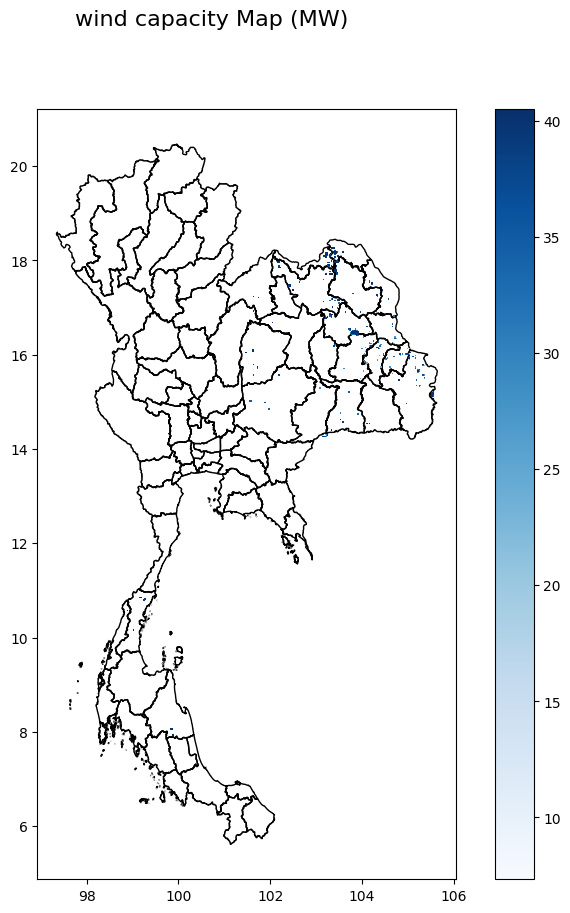

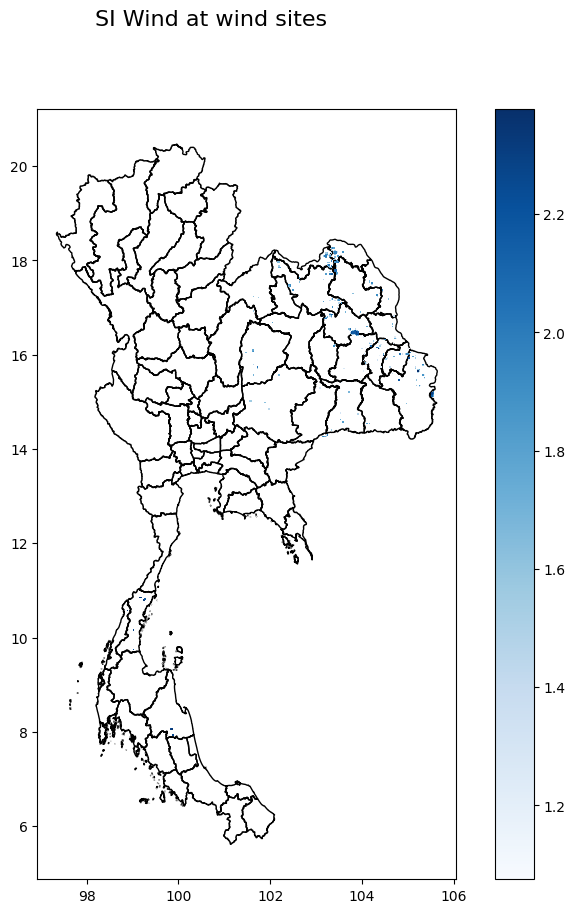

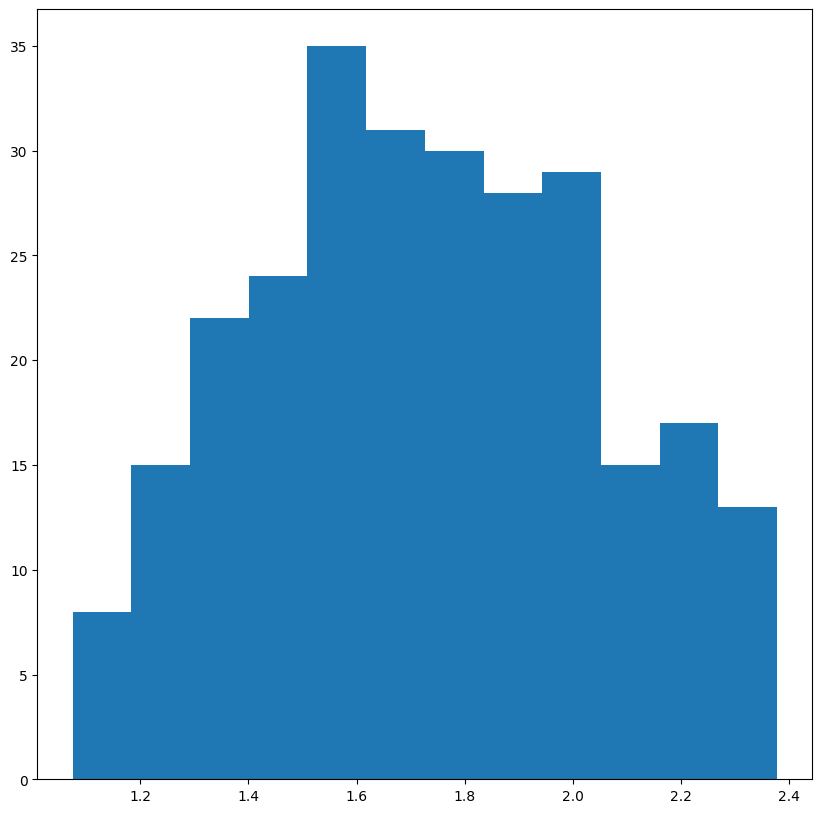

In [9]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind['cap_wind'].sum())
print("R0 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R0'].sum())
print("R1 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R1'].sum())
print("R2 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R2'].sum())
print("R3 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R3'].sum())
print("R4 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('wind capacity Map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'cap_wind',cmap = 'Blues')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SI Wind at wind sites', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df_wind['SI_Wind'],histtype ='barstacked',bins=12)

total solar capacity =  27424.998600000003
R0 Solar =  50.0
R1 Solar =  4949.9999
R2 Solar =  9149.999400000002
R3 Solar =  8474.9995
R4 Solar =  4799.9998


(array([ 1.,  1.,  0.,  0.,  0.,  0.,  4., 23., 41., 46., 90., 16.]),
 array([0.45558139, 0.64066408, 0.82574678, 1.01082947, 1.19591217,
        1.38099486, 1.56607756, 1.75116025, 1.93624295, 2.12132564,
        2.30640834, 2.49149103, 2.67657373]),
 <BarContainer object of 12 artists>)

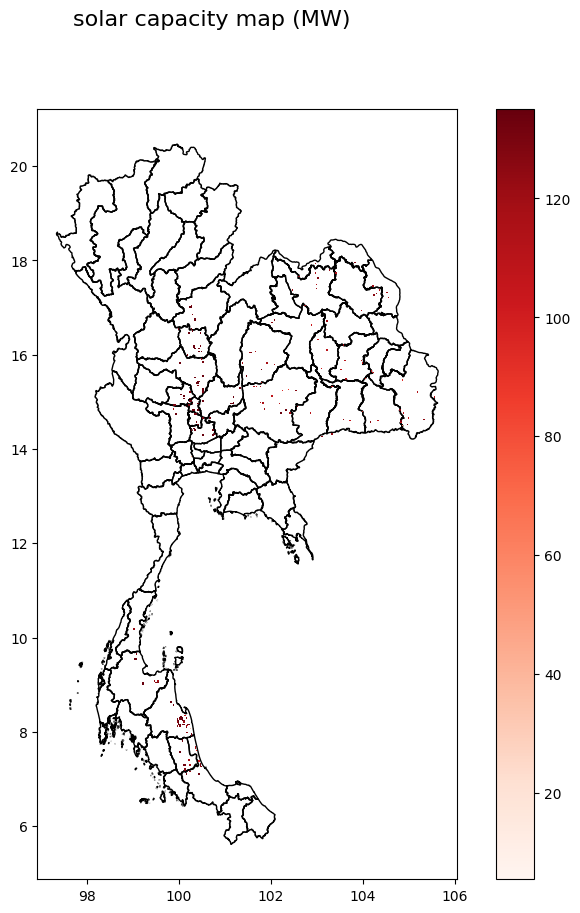

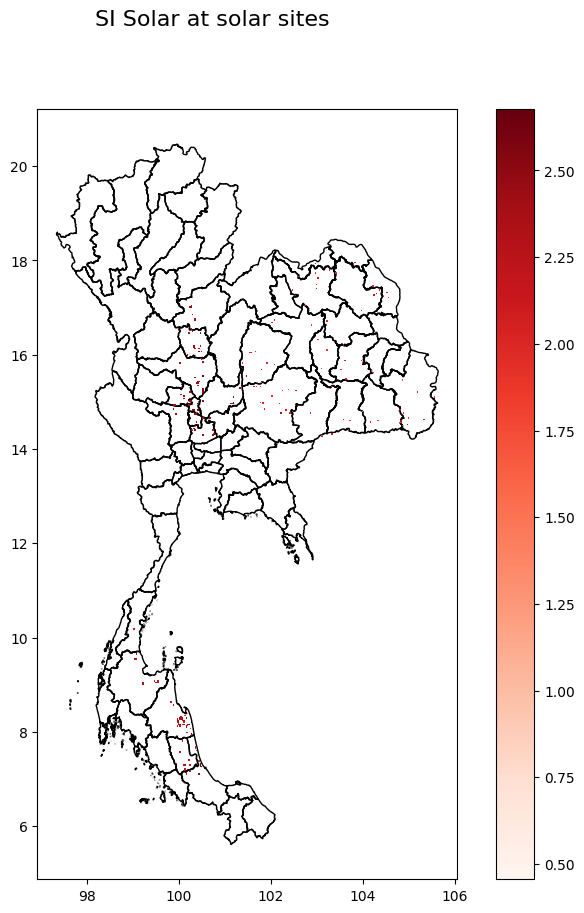

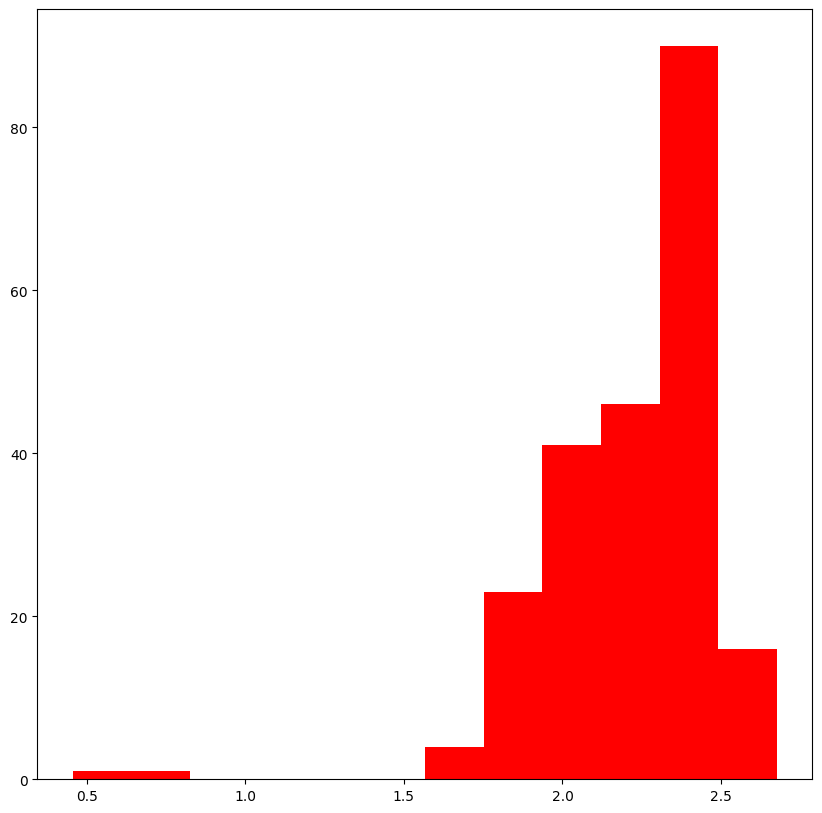

In [10]:
print("total solar capacity = ", df_solar['cap_solar'].sum())
print("R0 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R0'].sum())
print("R1 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R1'].sum())
print("R2 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R2'].sum())
print("R3 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R3'].sum())
print("R4 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('solar capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'cap_solar',cmap = 'Reds')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SI Solar at solar sites', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'SI_Solar',cmap = 'Reds')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df_solar['SI_Solar'],histtype ='barstacked',bins=12,color='red')

total biomass capacity =  710.65
R0 biomass =  0.0
R1 biomass =  148.96
R2 biomass =  260.0
R3 biomass =  70.7
R4 biomass =  230.99


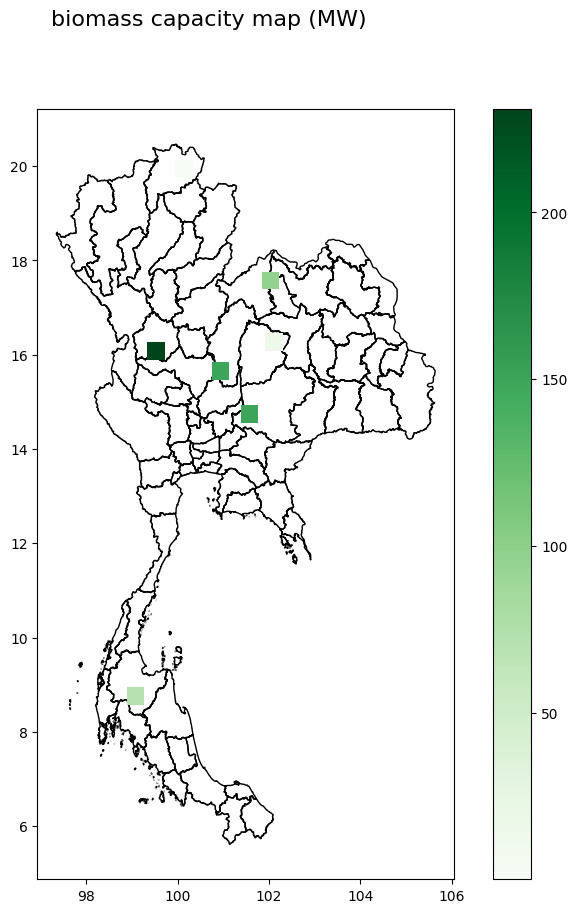

In [11]:
try:
    print("total biomass capacity = ", df_biomass['cap_biomass'].sum())
    print("R0 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R0'].sum())
    print("R1 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R1'].sum())
    print("R2 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R2'].sum())
    print("R3 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R3'].sum())
    print("R4 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R4'].sum())
except:
    None
    
fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('biomass capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_biomass.plot(ax = ax,legend=True,zorder = 1,column = 'cap_biomass',cmap = 'Greens')
except:
    None

total bgec capacity =  0.0
R0 bgec =  0.0
R1 bgec =  0.0
R2 bgec =  0.0
R3 bgec =  0.0
R4 bgec =  0.0


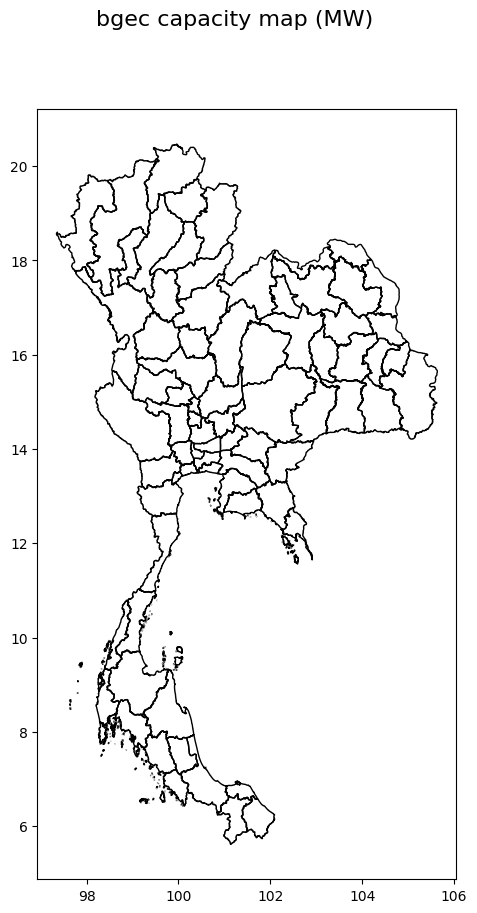

In [12]:
try:
    print("total bgec capacity = ", df_bgec['cap_bgec'].sum())
    print("R0 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R0'].sum())
    print("R1 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R1'].sum())
    print("R2 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R2'].sum())
    print("R3 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R3'].sum())
    print("R4 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R4'].sum())
    
except:
    None

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('bgec capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_bgec.plot(ax = ax,legend=True,zorder = 1,column = 'cap_bgec',cmap = 'Purples')
except:
    None

total msw capacity =  843.5001
R0 msw =  195.0
R1 msw =  219.52
R2 msw =  233.65
R3 msw =  104.3301
R4 msw =  91.0


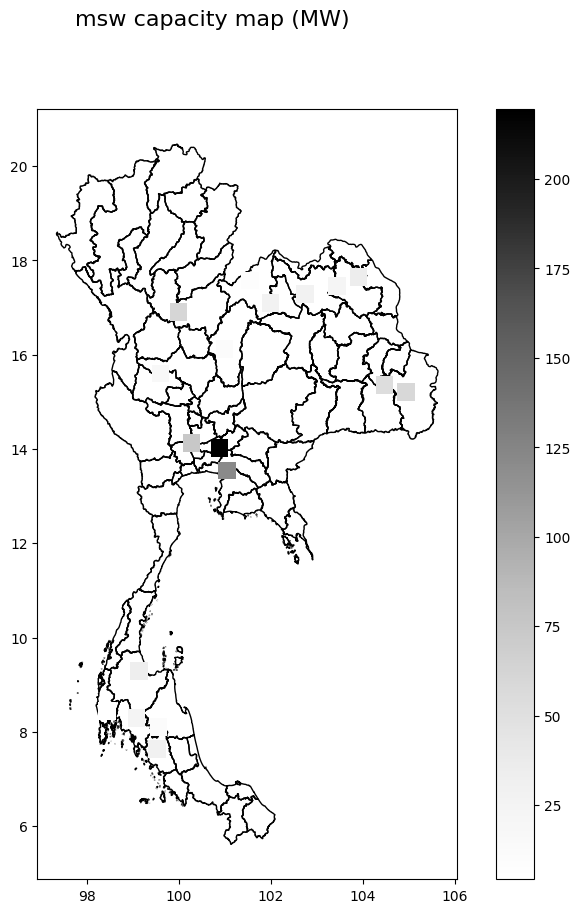

In [13]:
try:
    print("total msw capacity = ", df_msw['cap_msw'].sum())
    print("R0 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R0'].sum())
    print("R1 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R1'].sum())
    print("R2 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R2'].sum())
    print("R3 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R3'].sum())
    print("R4 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R4'].sum())
except:
    None

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('msw capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_msw.plot(ax = ax,legend=True,zorder = 1,column = 'cap_msw',cmap = 'Greys')
except:
    None

In [14]:
region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
list_region = []
count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
thailandmap['region'] = list_region

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


C:\Users\595078\AppData\Local\Temp\ipykernel_16224\864118982.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bound = specificarea.unary_union.bounds


total wind capacity =  450.0
total solar capacity =  8474.9995
total biomass capacity =  70.7
total bgec capacity =  0.0
total msw capacity =  104.3301


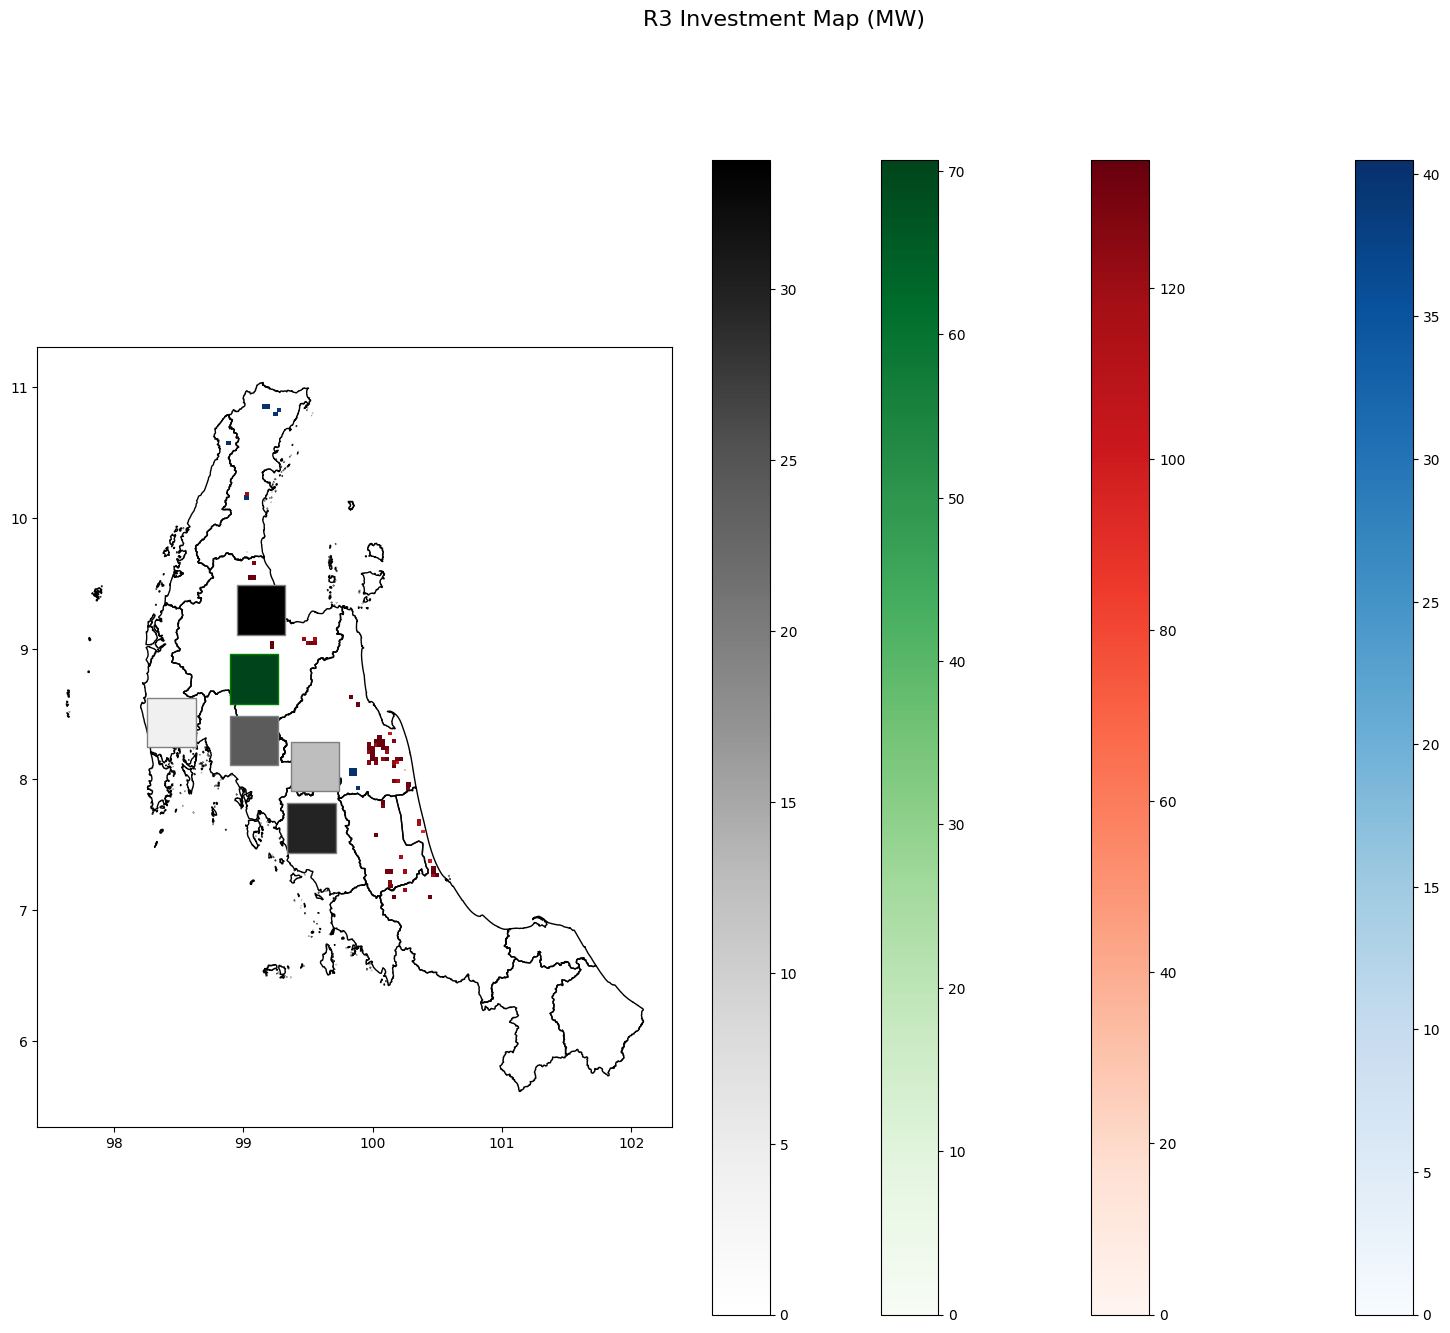

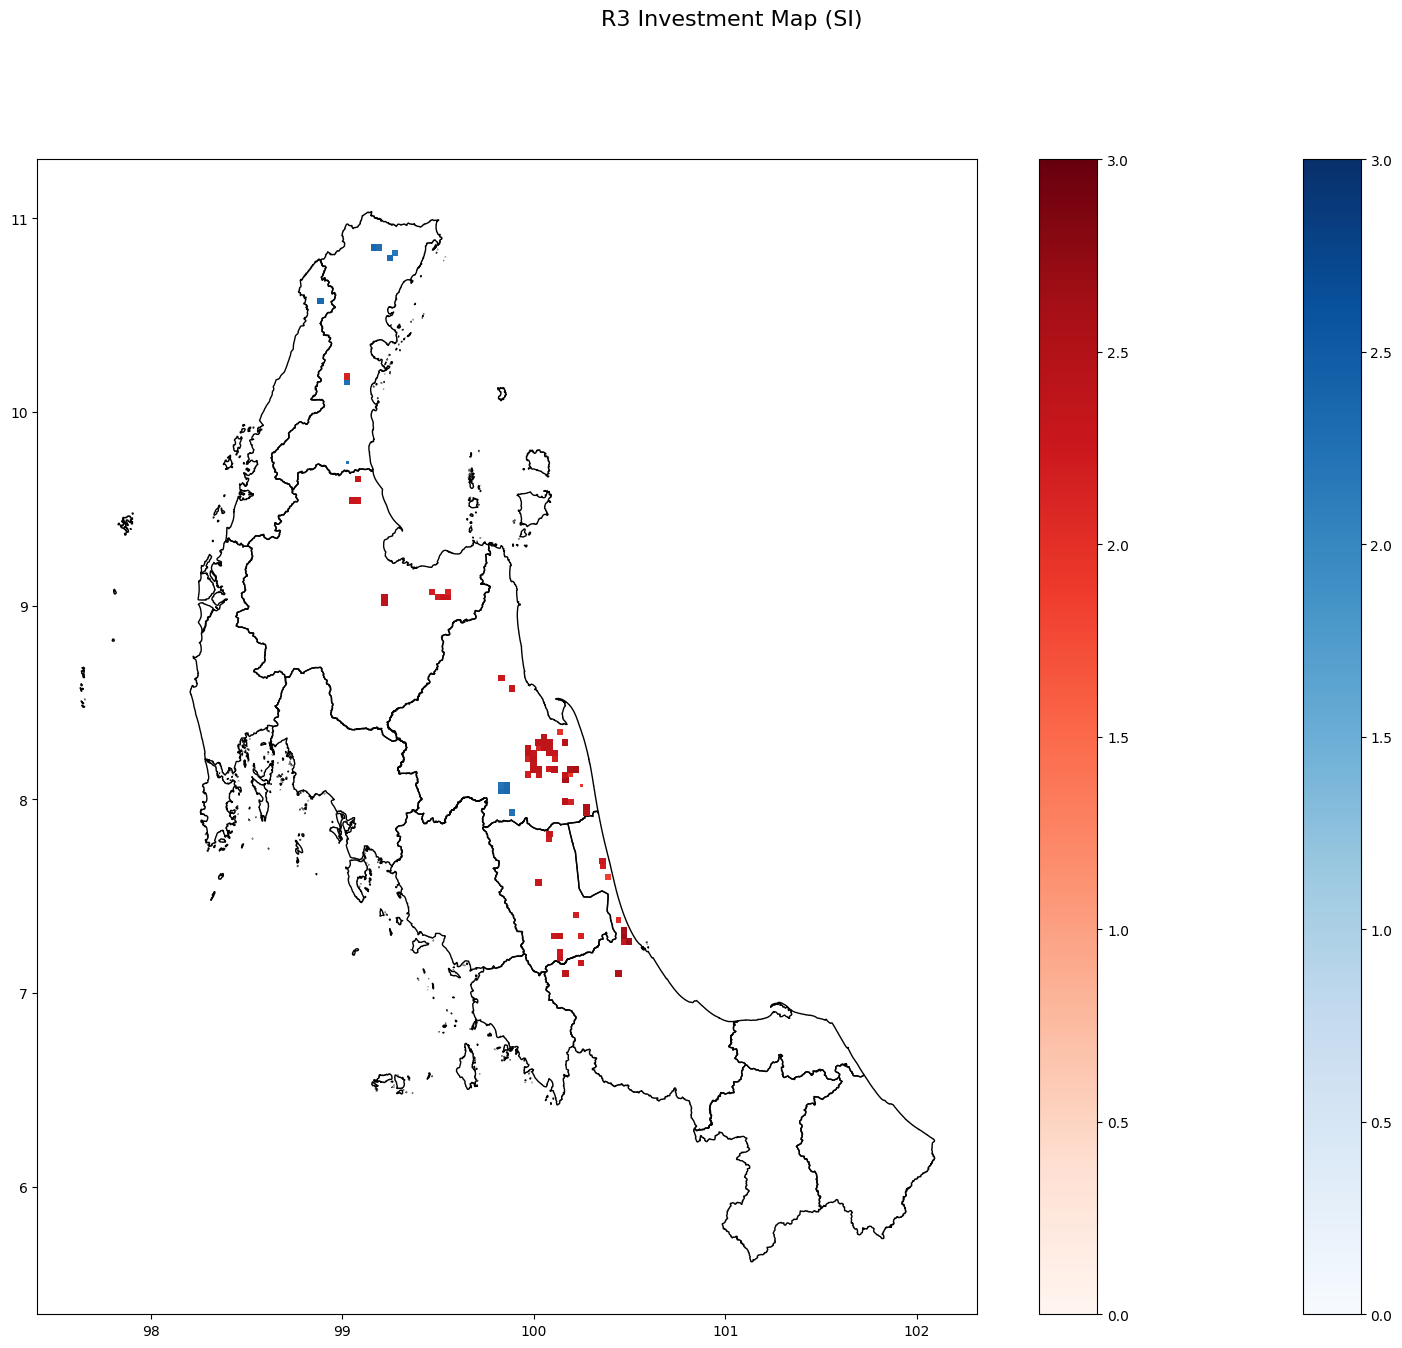

In [15]:
region = 'R3'
specificarea = thailandmap.loc[thailandmap['region'] == region]
bound = specificarea.unary_union.bounds
try:
    print("total wind capacity = ", df_wind['cap_wind'].loc[df_wind['region'] == region].sum())

    print("total solar capacity = ", df_solar['cap_solar'].loc[df_solar['region'] == region].sum())

    print("total biomass capacity = ", df_biomass['cap_biomass'].loc[df_biomass['region'] == region].sum())

    print("total bgec capacity = ", df_bgec['cap_bgec'].loc[df_bgec['region'] == region].sum())

    print("total msw capacity = ", df_msw['cap_msw'].loc[df_msw['region'] == region].sum())

except:
    None

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle(region + ' Investment Map (MW) ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['region'] == region].plot(ax = ax,legend = True,zorder = 1,column = 'cap_wind',cmap = 'Blues',vmin = 0)
except:
    None
try:
    df_solar.loc[df_solar['region'] == region].plot(ax = ax,legend = True,zorder = 2,column = 'cap_solar',cmap = 'Reds',vmin = 0)
except:
    None
try:
    df_biomass.loc[df_biomass['region'] == region].plot(ax = ax,legend = True,zorder = 3,column = 'cap_biomass',cmap = 'Greens',edgecolors = 'green',vmin = 0)
except:
    None
try:
    df_bgec.loc[df_bgec['region'] == region].plot(ax = ax,legend = True,zorder = 4,column = 'cap_bgec',cmap = 'Purples',edgecolors = 'purple',vmin = 0)
except:
    None
try:
    df_msw.loc[df_msw['region'] == region].plot(ax = ax,legend = True,zorder = 5,column = 'cap_msw',cmap = 'Greys',edgecolors = 'grey',vmin = 0)
except:
    None

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle(region + ' Investment Map (SI) ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['region'] == region].plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues',vmin = 0,vmax=3)
except:
    None
try:
    df_solar.loc[df_solar['region'] == region].plot(ax = ax,legend=True,zorder = 2,column = 'SI_Solar',cmap = 'Reds',vmin = 0,vmax=3)
except:
    None
# try:
#     df_biomass.loc[df_biomass['region'] == region].plot(ax = ax,legend=True,zorder = 3,column = 'SI_Biomass',cmap = 'Greens',edgecolors = 'green',vmin = 0,vmax=3)
# except:
#     None
# try:
#     df_bgec.loc[df_bgec['region'] == region].plot(ax = ax,legend=True,zorder = 4,column = 'SI_BGEC',cmap = 'Purples',edgecolors = 'purple',vmin = 0,vmax=3)
# except:
#     None
# try:
#     df_msw.loc[df_msw['region'] == region].plot(ax = ax,legend=True,zorder = 5,column = 'SI_MSW',cmap = 'Greys',edgecolors = 'grey',vmin = 0,vmax=3)
# except:
#     None